<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble learning

## Preparation

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [181]:
pd.set_option('float_format', '{:f}'.format)
plt.rcParams.update({'font.size': 16})

df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [182]:
from sklearn.model_selection import train_test_split

def preprocessing(X, y, preprocessor=None, test_size=0.2, random_state=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,
                                                      random_state=random_state)
    if preprocessor is not None:
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
    return X_train, X_val, y_train.values, y_val.values

In [183]:
from sklearn.preprocessing import StandardScaler

X, y = df[["GrLivArea", "YearBuilt"]], df["SalePrice"]
X_train, X_val, y_train, y_val = preprocessing(X, y, StandardScaler(), random_state=0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1168, 2), (292, 2), (1168,), (292,))

## [Problem 1] Blending scratch mounting

In [184]:
class ScratchBlendingRegressor():
    """
    @Attributes:
        models: list of models used for blending
        weighting: whether or not weighting the estimation results
    """
    def __init__(self, models, weights=[]):
        self.models = models
        if len(weights) > 0:
            weights = np.array(weights) / np.sum(weights)
        self.weights = weights
    
    def fit(self, X, y):
        for i, model in enumerate(self.models):
            model.fit(X, y)
        return self
        
    def predict(self, X):
        y_preds = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            y_preds[:, i] = model.predict(X)

        if len(self.weights) == len(self.models):
            return y_preds @ self.weights
        else:
            # Simply take average
            return y_preds.mean(axis=1)

In [185]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

def train_and_evaluate(X_train, X_val, y_train, y_val, model=DummyRegressor()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

def plot_comparison(model_scores, title="Compare results"):
    mse = []
    model_names = []
    for name, score in model_scores:
        model_names.append(name)
        mse.append(score)
    mse = np.array(mse)
    model_names = np.array(model_names)

    normalized_mse = mse / np.sum(mse)
    idx = np.argsort(mse)
    sort_names = model_names[idx]
    df = pd.DataFrame(index=sort_names, columns=["mse"])
    df.loc[sort_names, "mse"] = mse[idx]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(idx)), normalized_mse[idx[::-1]], color='b')
    plt.yticks(range(len(idx)), sort_names[::-1])
    plt.xlabel("Mean squared error")
    plt.show()
    return df

### Models with default hyperparameters

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

blend_models = [
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor()
]
weights = [0.5, 0.15, 0.35]
models = [
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Normal/Avg Blending", ScratchBlendingRegressor(blend_models)),
    ("Weighted Blending", ScratchBlendingRegressor(blend_models, weights))
]
model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in models]

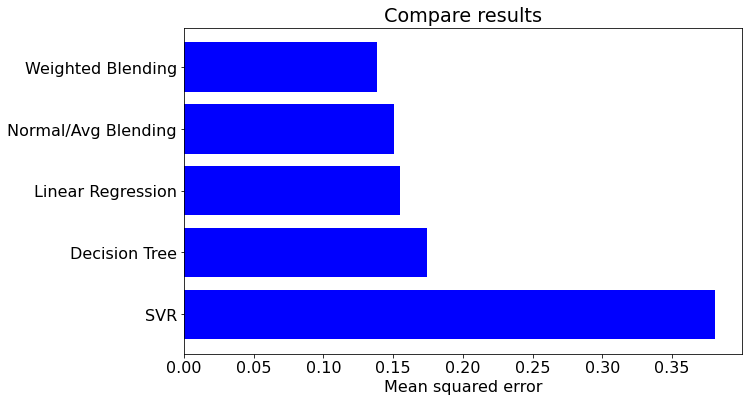

,mse
Weighted Blending,2631198277.664351
Normal/Avg Blending,2854173839.709363
Linear Regression,2942066921.672107
Decision Tree,3307764785.583714
SVR,7221625115.268777


In [187]:
plot_comparison(model_scores)

### Models with selected hyperparamters

In [188]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Linear SVR", SVR(kernel='linear')),
    ("Poly SVR", SVR(kernel='poly')),
    ("MAE Decision Tree", DecisionTreeRegressor(criterion='mae')),
    ("MSE Decision Tree", DecisionTreeRegressor(criterion='mse')),
]
blend_list = [model[1] for model in models]
models.append(("Normal/Avg Blending", ScratchBlendingRegressor(blend_list)))
model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in models]

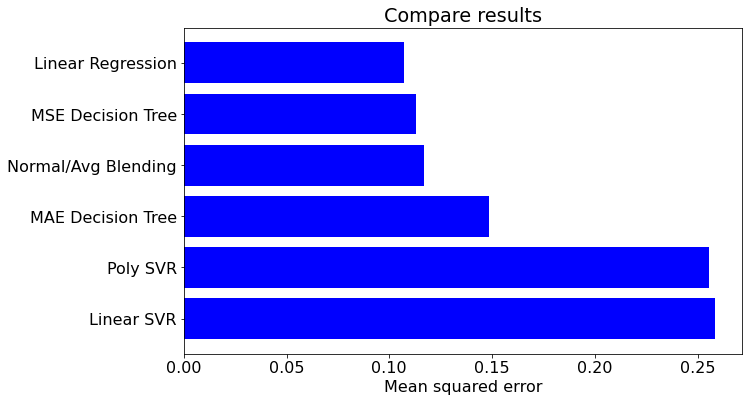

,mse
Linear Regression,2942066921.672107
MSE Decision Tree,3102421482.676180
Normal/Avg Blending,3209905472.901355
MAE Decision Tree,4073140300.253425
Poly SVR,7003035861.122121
Linear SVR,7092012854.934424


In [189]:
plot_comparison(model_scores)

### Decision Tree with different hyperparameter

In [190]:
params = {
    "criterion": ["mae", "mse"],
    "max_depth": [50, 100, 200, 500]
}
models = []
for crit in params["criterion"]:
    for depth in params["max_depth"]:
        name = f"{crit.upper()} Decision Tree ({depth})"        
        models.append((name, DecisionTreeRegressor(criterion=crit,
                                                   max_depth=depth,
                                                   random_state=0)))
blend_list = [model[1] for model in models]
models.append(("Normal/Avg Blending", ScratchBlendingRegressor(blend_list)))
model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in models]

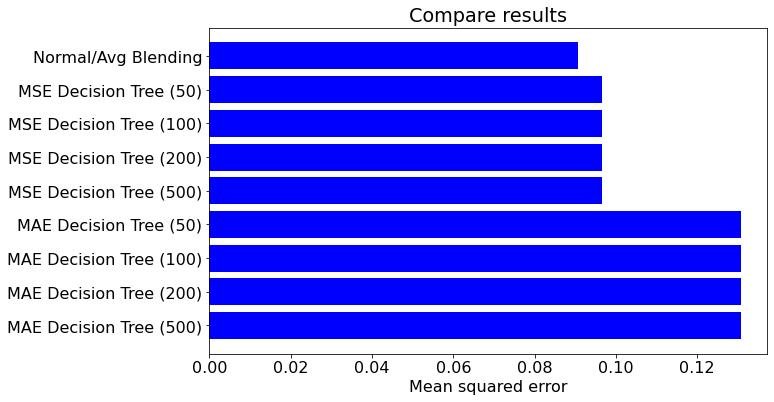

,mse
Normal/Avg Blending,2831257060.628805
MSE Decision Tree (50),3015859667.659056
MSE Decision Tree (100),3015859667.659056
MSE Decision Tree (200),3015859667.659056
MSE Decision Tree (500),3015859667.659056
MAE Decision Tree (50),4082065212.020548
MAE Decision Tree (100),4082065212.020548
MAE Decision Tree (200),4082065212.020548
MAE Decision Tree (500),4082065212.020548


In [191]:
plot_comparison(model_scores)

## [Problem 2] Scratch mounting of bagging

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

class ScratchBaggingRegressor():
    """
    @Attributes:
        base_estimator: base estimator used for training different subsets
        n_estimators: number of estimators
        max_samples: in range of [0, 1], proportion of subset over whole dataset
    """
    def __init__(self, base_estimator=DecisionTreeRegressor(), n_estimators=10,
                 max_samples=0.5, random_state=None, verbose=False):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.verbose = verbose
    
    def _gen_seeds(self, N):
        np.random.seed(self.random_state)
        self.seeds = np.random.choice(N, self.n_estimators, replace=False)
    
    def _evaluate_estimator(self, X, y, estimator):
        y_pred = estimator.predict(X)
        return mean_squared_error(y, y_pred)
    
    def fit(self, X, y):
        self._gen_seeds(X.shape[0])
        self.estimators = []
        for i in range(self.n_estimators):
            X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=self.max_samples,
                                                              random_state=self.seeds[i])
            estimator = clone(self.base_estimator)
            estimator.fit(X_train, y_train)
            self.estimators.append(estimator)

            if self.verbose:
                mse = self._evaluate_estimator(X_val, y_val, estimator)
                print("Estimator", i, "MSE", mse)
        return self
    
    def predict(self, X):
        y_preds = np.zeros((X.shape[0], len(self.estimators)))
        for i, estimator in enumerate(self.estimators):
            y_preds[:, i] = estimator.predict(X)
        return y_preds.mean(axis=1)

### Running scratch

In [193]:
base_lr = LinearRegression()
base_svr = SVR()
base_dtree = DecisionTreeRegressor(random_state=0)
models = [
    ("Linear Regression", base_lr),
    ("SVR", base_svr),
    ("Decision Tree", base_dtree),
    ("Bagging Linear Regression", ScratchBaggingRegressor(base_estimator=base_lr,
                                                          random_state=0)),
    ("Bagging SVR", ScratchBaggingRegressor(base_estimator=base_svr,
                                            random_state=0)),
    ("Bagging Decision Tree", ScratchBaggingRegressor(base_estimator=base_dtree,
                                                      random_state=0)),
]

model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in models]

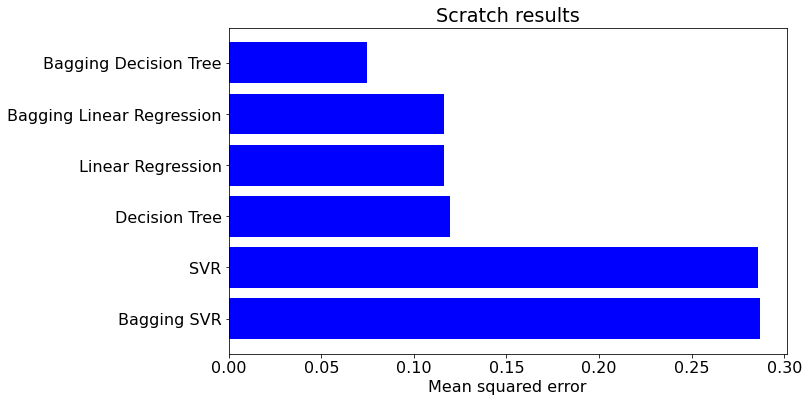

,mse
Bagging Decision Tree,1885705942.594179
Bagging Linear Regression,2941713866.676823
Linear Regression,2942066921.672107
Decision Tree,3015859667.659056
SVR,7221625115.268777
Bagging SVR,7246792511.012195


In [194]:
plot_comparison(model_scores, "Scratch results")

### Running Sklearn to compare

In [195]:
from sklearn.ensemble import BaggingRegressor

models = [
    ("Linear Regression", base_lr),
    ("SVR", base_svr),
    ("Decision Tree", base_dtree),
    ("Bagging Linear Regression", BaggingRegressor(base_estimator=base_lr, random_state=0)),
    ("Bagging SVR", BaggingRegressor(base_estimator=base_svr, random_state=0)),
    ("Bagging Decision Tree", BaggingRegressor(base_estimator=base_dtree, random_state=0)),
]

model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in models]

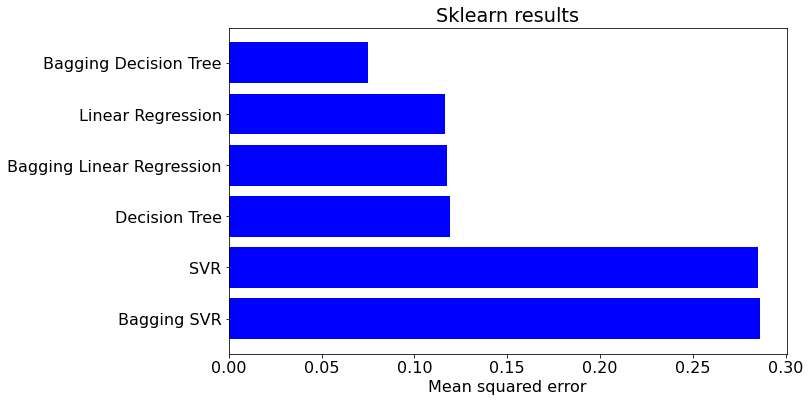

,mse
Bagging Decision Tree,1904987777.051497
Linear Regression,2942066921.672107
Bagging Linear Regression,2979450668.084227
Decision Tree,3015859667.659056
SVR,7221625115.268777
Bagging SVR,7243935599.277979


In [196]:
plot_comparison(model_scores, "Sklearn results")

## [Problem 3] Stacking scratch mounting

In [197]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

class ScratchStackingRegressor():
    """
    A 2-stage stacking regressor:
        Stage 1: train on estimator from list of estimators
        Stage 2: train blend data on final estimator
    @Attributes:
        estimators: list of estimators with each element if a tuple of (name, estimator)
        final_estimator: aggregator model
        cv: number of data pieces to be divided
    """
    def __init__(self, estimators, final_estimator=LinearRegression(),
                 cv=3, random_state=None, verbose=False):
        self.estimators = estimators
        self.final_estimator = final_estimator
        self.cv = cv
        self.random_state = random_state
        self.verbose = verbose
    
    def fit(self, X, y):
        self.models = list()
        blends = list()
        # Base learning
        kf = KFold(n_splits=self.cv, shuffle=True,
                   random_state=self.random_state)
        for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
            blend_data = np.empty((len(test_idx), len(self.estimators) + 1))
            trained_models = []
            for j, (name, estimator) in enumerate(self.estimators):
                model = clone(estimator)
                model.fit(X[train_idx], y[train_idx])
                y_pred = model.predict(X[test_idx])

                blend_data[:, j] = y_pred
                trained_models.append(model)

                # Print learning process if verbose is set to True
                if self.verbose:
                    mse = mean_squared_error(y[test_idx], y_pred)
                    print(f"KFold {i + 1} {name:30} {mse}")

            blend_data[:, -1] = y[test_idx]
            blends.append(blend_data)
            self.models.append(trained_models)

        self.blend_data = np.vstack(blends)

        # Meta learning
        self.final_estimator.fit(self.blend_data[:,:-1], self.blend_data[:,-1])

        return self
    
    def predict(self, X):
        blend_test = np.zeros((X.shape[0], len(self.estimators)))
        for row_models in self.models:
            base_pred = np.zeros_like(blend_test)
            for i, model in enumerate(row_models):
                base_pred[:, i] = model.predict(X)
            blend_test += base_pred
        blend_test /= self.cv

        return self.final_estimator.predict(blend_test)

In [198]:
from sklearn.ensemble import StackingRegressor

models = [
    ("Linear Regression", base_lr),
    ("SVR", base_svr),
    ("Decision Tree", base_dtree)
]
scratch_stack = ScratchStackingRegressor(estimators=models, cv=5)
sklearn_stack = StackingRegressor(estimators=models, final_estimator=LinearRegression(), cv=5)

model_list = [
    ("Linear Regression", base_lr),
    ("SVR", base_svr),
    ("Decision Tree", base_dtree),
    ("Scratch Stacking Regressor", scratch_stack),
    ("Sklearn Stacking Regressor", sklearn_stack)
]
model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in model_list]

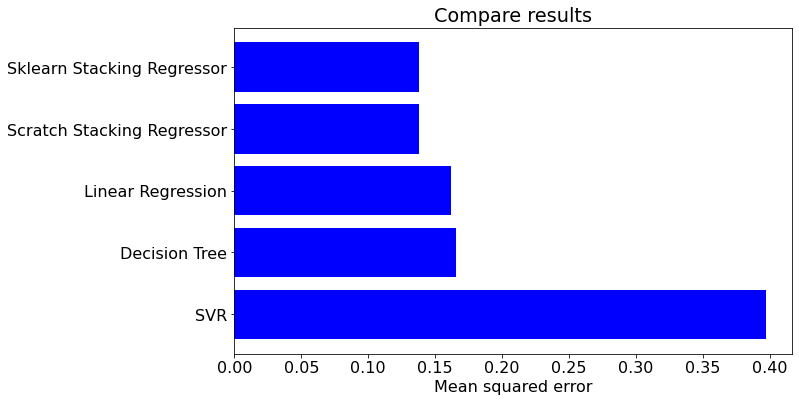

,mse
Sklearn Stacking Regressor,2510492547.850051
Scratch Stacking Regressor,2513024901.264619
Linear Regression,2942066921.672107
Decision Tree,3015859667.659056
SVR,7221625115.268777


In [199]:
plot_comparison(model_scores)

## Experiment

Try with complex mix of models, final_estimator is LinearRegression

In [200]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

models = [
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("KNeighbors", KNeighborsRegressor()),
    ("Random Forest", RandomForestRegressor())
]
scratch_stack = ScratchStackingRegressor(estimators=models, cv=10)
sklearn_stack = StackingRegressor(estimators=models, final_estimator=LinearRegression(), cv=10)

model_list = models.copy()
model_list.append(("Scratch Stacking Regressor", scratch_stack))
model_list.append(("Sklearn Stacking Regressor", sklearn_stack))

model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in model_list]

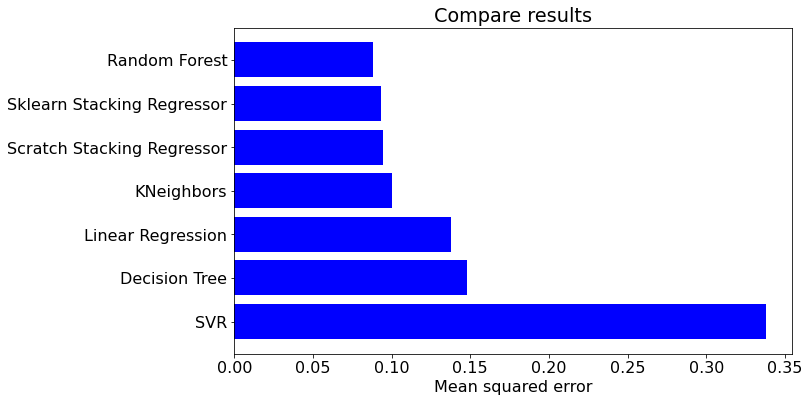

,mse
Random Forest,1888687587.741518
Sklearn Stacking Regressor,1991361390.330312
Scratch Stacking Regressor,2022801688.947981
KNeighbors,2147632008.770137
Linear Regression,2942066921.672107
Decision Tree,3163458837.528919
SVR,7221625115.268777


In [201]:
plot_comparison(model_scores)

Change final_estimator to RidgeCV - default of Sklearn, but set default hyperparameters.

In [202]:
from sklearn.linear_model import RidgeCV

models = [
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("KNeighbors", KNeighborsRegressor()),
    ("Random Forest", RandomForestRegressor())
]
scratch_stack = ScratchStackingRegressor(estimators=models, final_estimator=RidgeCV(), cv=10)
sklearn_stack = StackingRegressor(estimators=models, cv=10)

model_list = models.copy()
model_list.append(("Scratch Stacking Regressor", scratch_stack))
model_list.append(("Sklearn Stacking Regressor", sklearn_stack))

model_scores = [(model[0], train_and_evaluate(X_train, X_val, y_train, y_val, model[1]))
                for model in model_list]

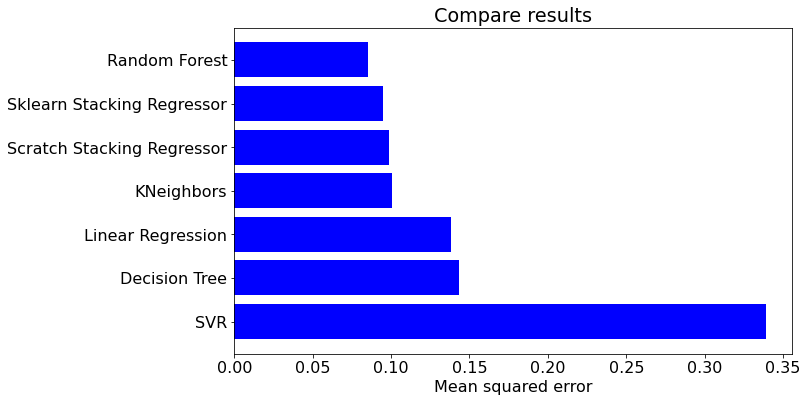

,mse
Random Forest,1820819473.283647
Sklearn Stacking Regressor,2014159313.231989
Scratch Stacking Regressor,2103842881.110054
KNeighbors,2147632008.770137
Linear Regression,2942066921.672107
Decision Tree,3055024544.039193
SVR,7221625115.268777


In [203]:
plot_comparison(model_scores)